# 04. PyTorch Custom Datasets Video Notebook

Resource: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb


## Domain Libraries

Depending on what you are working on, vision, text, audio, recommendation, you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable functions


We've used some datasets with PyTorch before

But how do you get your data into PyTorch

One of the ways to do so is via custom datasets

## 0. Importing PyTorch and setting up device-agnostic code

In [92]:
import torch
from torch import nn

torch.__version__

'2.1.0+cu121'

In [93]:
# Setup device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1. Get data

Our dataset is a subset of the Food101 dataset

Food10 starts 101 different classes of food and 1000 images per class (750 training : 250 testing)

Our dataset starts with 3 classes of food and only 10% of the images. (~75 training : 25 testing)

Why do this?

When starting out ML project, it's important to try things on a small scale when necessary.

The whole point is to speed up how fast you can experiment



In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path  = Path("data/")
image_path = data_path / "pizza_steak_sushi"
zip_path   = "pizza_steak_sushi.zip"

# If the image folder doesn't exist, download it and prepare it
if image_path.is_dir():
  print(f"{image_path} directory exists, skipping download")
else:
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

  # download zip data
  with open(data_path / zip_path, "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Download pizza, steak, sushi data...")
    f.write(request.content)

  # Unzip data
  with zipfile.ZipFile(data_path / zip_path, 'r') as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Download pizza, steak, sushi data...
Unzipping pizza, steak, sushi data...


## 2. Become one with the data (data preparation)

In [ ]:
import os
def walk_through_dir(dir_path):
  """ Walk through dir_path returning its content."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'


In [ ]:
# setup train and testing paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2.1 Visualize an image


Let's write some code to:
1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name `pathlib.Path.parent.stem`
4. Since we're working with Images, use PIL to open image
5. show image and print data

Random image path: data/pizza_steak_sushi/train/pizza/702165.jpg
Image class: pizza
Image height: 512
Image width: 512


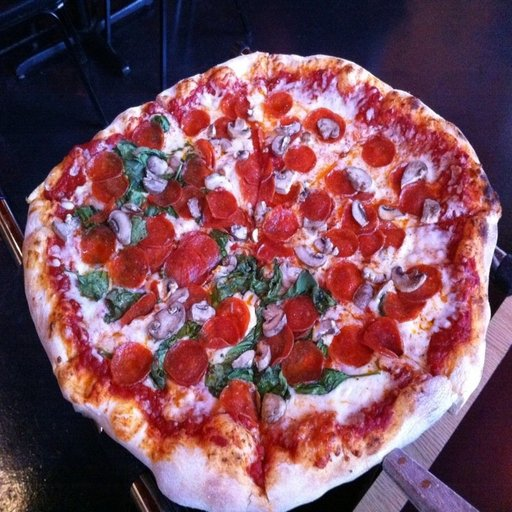

In [ ]:
import random
from PIL import Image

# Set seed
random.seed(15)

# 1. Get all image path (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class
# is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

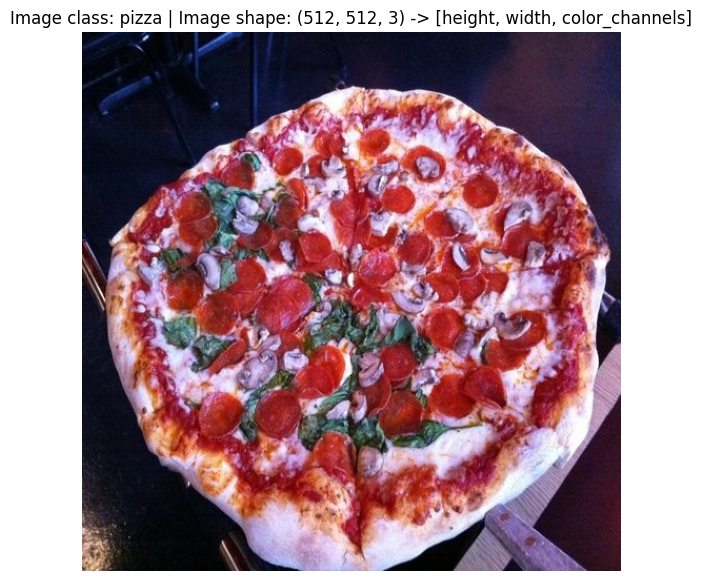

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

## 3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in our case, numerical representation of our images)

2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we will call these `Dataset` and `DataLoader`

Since we're working with a **vision** problem, we'll be looking at **torchvision**.datasets for our data loading functions as well as **torchvision.transforms** for preparing our data.

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

Trasform help you get your images ready to be used with a model/perform data augmentation

In [ ]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the image to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into torch.Tensor
    transforms.ToTensor() # this also converts all pixel values for 0 to 255 to be between 0.0 to 1.0
])

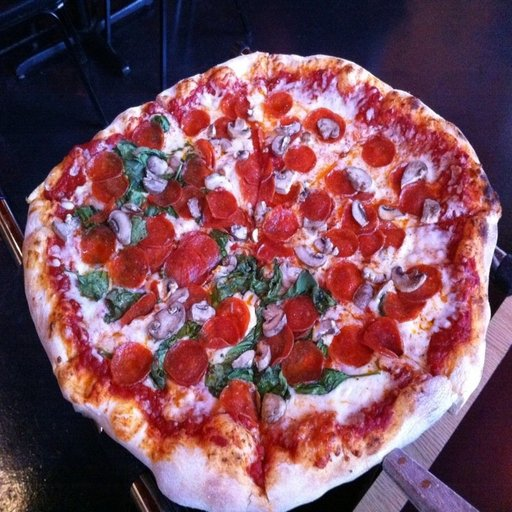

In [ ]:
# PIL Image
img

In [ ]:
data_transform(img), data_transform(img).shape, data_transform(img).dtype

(tensor([[[0.1333, 0.1529, 0.1843,  ..., 0.0431, 0.0353, 0.0353],
          [0.1333, 0.1569, 0.1922,  ..., 0.0314, 0.0471, 0.0510],
          [0.1294, 0.1529, 0.1882,  ..., 0.0275, 0.0196, 0.0235],
          ...,
          [0.2431, 0.2157, 0.1961,  ..., 0.5882, 0.6235, 0.7216],
          [0.2353, 0.2118, 0.1922,  ..., 0.5882, 0.6824, 0.7255],
          [0.2078, 0.1882, 0.1843,  ..., 0.5569, 0.7765, 0.7059]],
 
         [[0.1216, 0.1333, 0.1373,  ..., 0.0784, 0.0549, 0.0353],
          [0.1176, 0.1216, 0.1333,  ..., 0.0627, 0.0745, 0.0706],
          [0.1216, 0.1176, 0.1294,  ..., 0.0549, 0.0510, 0.0510],
          ...,
          [0.0824, 0.0745, 0.0706,  ..., 0.4627, 0.4784, 0.5686],
          [0.0784, 0.0784, 0.0706,  ..., 0.4431, 0.5333, 0.5725],
          [0.0745, 0.0745, 0.0706,  ..., 0.4235, 0.6196, 0.5569]],
 
         [[0.2275, 0.2353, 0.2392,  ..., 0.1922, 0.1255, 0.0863],
          [0.2431, 0.2431, 0.2431,  ..., 0.1686, 0.1843, 0.1765],
          [0.2549, 0.2549, 0.2510,  ...,

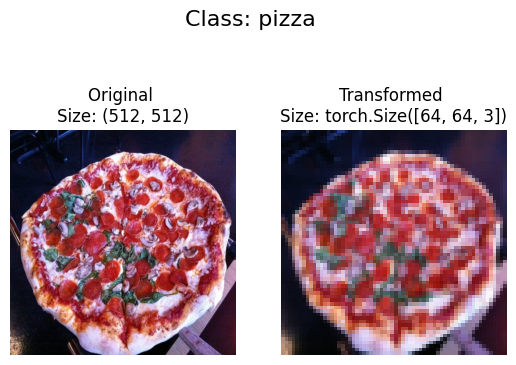

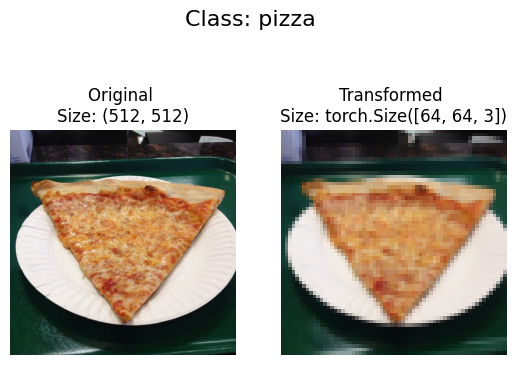

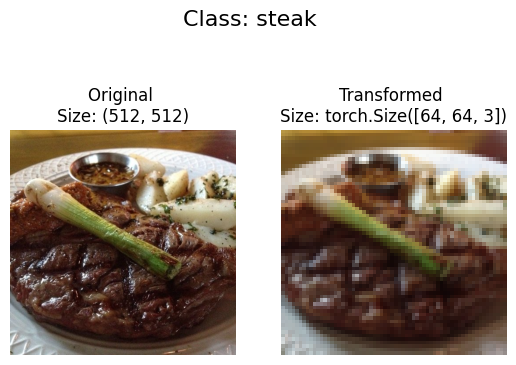

In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed=15):
  """ Plots a sries of random images from image_paths.

  Will open n image paths from image_paths, transform them
  with transform and plot them side by side

  Args:
  image_paths (list) : List of target image paths.
  transform (PyTorch Transform)  Transforms to apply to images
  n (int, optional) : Number of images to plot
  seed (int, optional) : Random seed for the random generator
  """

  random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize: {f.size}")
      ax[0].axis("off")

      # Transform and plot image
      # Note: permute() will change shape of image to suit matplotlib
      transformed_image = transform(f).permute(1, 2, 0) # note we will need to change for matplitlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.dataset.ImageFolder`

In [ ]:
# Use ImageFolder to create datasets
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transform to perform on data (images)
                                  target_transform=None) # transform to perform on Labels (if necessary)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [ ]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# Check the lengths
len(train_data), len(test_data)

(225, 75)

In [ ]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


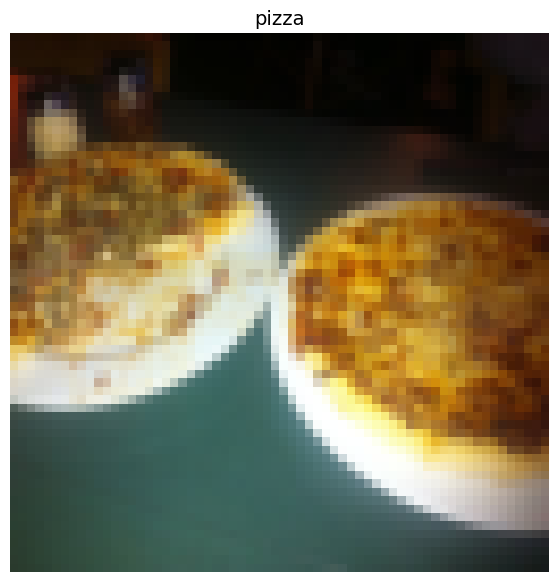

In [ ]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

### 4.1 Turn loaded image into `DataLoader`

a `DataLoader` is going to helps us turn our `Dataset` into iterable and we can customise the `batch_size` images at a time

In [ ]:
import os
os.cpu_count()
BATCH_SIZE = 1

In [ ]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE, # how many samples per batch?
                              num_workers=os.cpu_count(), # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x784a5c27a800>,
 <torch.utils.data.dataloader.DataLoader at 0x784a5c27a530>)

In [ ]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [ ]:
len(train_data), len(test_data)

(225, 75)

In [ ]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 5. Option 2: Loading Image Data with a Custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

**Pros**:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

**Cons**:
* Even though you could create `Dataset` out of almost anything, it doesn't mean it will work
* Using a custom `Dataset` often results in us writing more code, which code be prone to errors or performance issues

All custom datasets in PyTorch, often subclass torch.utils.data.Dataset

In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [ ]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to transverse a target directory (ideally the directory is in the standard image classification format)

2. Raise an error if the class names aren't found (if this happens, there might be something wrong with th directory structure )

3. Turn the class names into a dict and a list and return them

In [ ]:
# Setup path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")


Target directory: data/pizza_steak_sushi/train
Class names found: ['pizza', 'steak', 'sushi']


In [ ]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory.

    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))

    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names not found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

  # 3. Create a dictionary of index labels (computer prefer numerical rahter than string)
  class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
  return classes, class_to_idx


In [ ]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `Imagefolder`

To create our own custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with target directory (the directory we would like to get data from) as well as a transform if we would like to transform our data
3. Create several attribute:
  * paths - paths of our images
  * transform - the transform we would like to use
  * classes - a list of target classes
  * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return to a given sample when passed an index


In [ ]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

  # 2. Initialize with a targ_dir and transform (optional) parameter
  def __init__(self, targ_dir:str, transform=None)->None:

    # 3. create class attributes
    # Get all image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # change between jpg and png
    # Setup transform
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Make function to load images
  def load_image(self, index:int) -> Image.Image:
    "Open an image via a path and return it"
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite the __len()__ method (optional but rec for subclasses of torch.utils.data.Dataset)
  def __len__(self) -> int:
    "Return the total number of samples"
    return len(self.paths)

  # 6. Overwrite the __getitem()__ method (optional but rec for subclasses of torch.utils.data.Dataset)
  "Returns one sample of data, data and label (X, y)"
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label (X, y)
    else:
      return img, class_idx # return data, label (X, y)


In [ ]:
# Augment train data
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape!!!
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [ ]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transform)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                      transform=test_transform)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x784a5c27b610>,
 <__main__.ImageFolderCustom at 0x784a5c279b70>)

In [ ]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [ ]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [ ]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many image to visualize
2. To precent the display getting out of hand, let's  cap the number of images to see at 10
3. Set the random seed for reproducibility
4. Get a list of random sample indexs from the target dataset
5. Setup a matplotlib plot
6. Loop through the random sample images then plot with matplotlib
7. Make sure sample images are of shape HWC (height, width, color channel)


In [ ]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

  # 2. Adjust if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

  # 3. Set random seed
  if seed:
    random.seed(seed)

  # 4.Get random sample indexs
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. Setup plot
  plt.figure(figsize=(16, 8))

  # 6. Loop through samples and display random samples
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. adjust image tensor shape for plotting: [color_channels, height, width] -> [width, height, color_channel]
    targ_image_adjust = targ_image.permute(1, 2, 0)

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\n shape: {targ_image_adjust.shape}"
    plt.title(title)

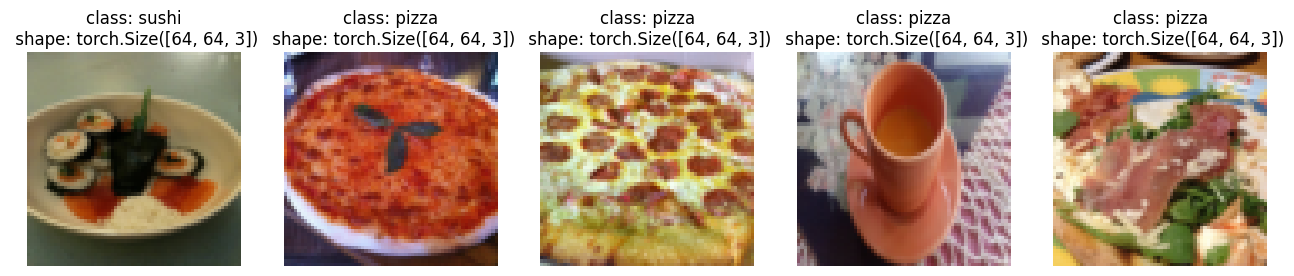

In [ ]:
# Display rndom images from ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

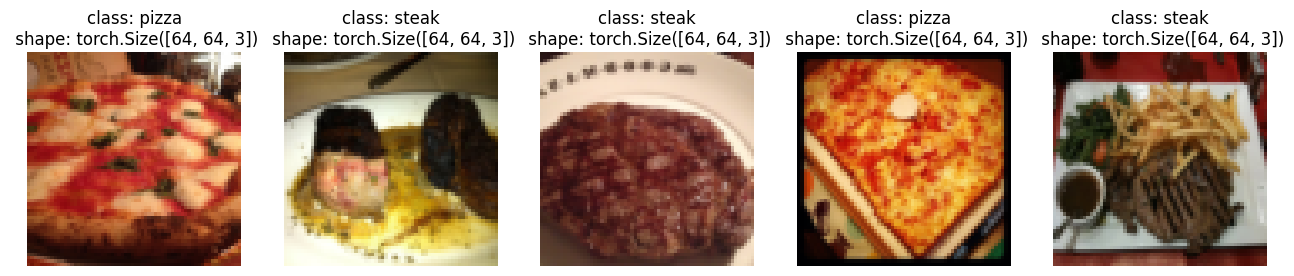

In [ ]:
# Display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=5,
                      classes=class_names,
                      seed=None)

### 5.4 Turn custom loaded images into DataLoader's

In [ ]:
# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader

BATCH_SIZE = 1
NUM_WORKERS =os.cpu_count()

train_dataloader_custom = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                                     batch_size=BATCH_SIZE,  # how many samples per batch?
                                     num_workers=NUM_WORKERS, # how many subprocesses to use for data loading? higher = more
                                     shuffle=True)  # shuffle the data?

test_dataloader_custom = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False) # we don't normally shuffle testing data

train_dataloader_custom, test_dataloader_custom, NUM_WORKERS

(<torch.utils.data.dataloader.DataLoader at 0x796a83b432b0>,
 2)

In [ ]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above abd see what's happen
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 6. Other forms of transforms (data augmentation)

Data augmentation is the process of artifically adding diversity to your training data

In the case of image data, this may mean applying various image transformations to the training images.

This practice hopefully results in a model tht's more generalizable to unseen data

Let's take a look at one particulr type of data augmentation used to train PyTorch vision models to state of the art levels...

url: https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/#break-down-of-key-accuracy-improvements

In [ ]:
# Let's look at TrivialAugment
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # range of intensity value, 0 = no range, 31 = max range
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

**Note**: You usually don't perform data augmentation on the test set. The idea of data augmentation is to to artificially increase the diversity of the training set to better predict on the testing set.

However, you do need to make sure your test set images are transformed to tensors. We size the test images to the same size as our training images too, however, inference can be done on different size images if necessary (though this may alter performance).

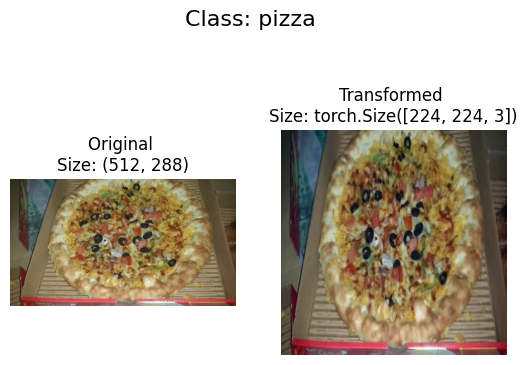

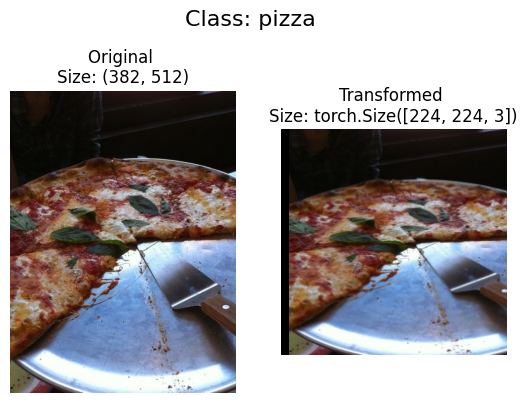

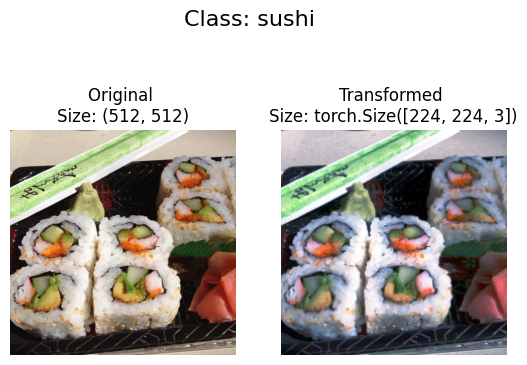

In [ ]:
# Get all image paths
image_path_lib = list(image_path.glob('*/*/*.jpg'))

# Plot random transformed images
plot_transformed_images(
    image_paths=image_path_lib,
    transform=train_transforms,
    n=3,
    seed=None
)

## 7. Model 0: TinyVGG without data augmentation

Lets replicate TinyVGG architecture from the CNN Explainer website:
https://poloclub.github.io/cnn-explainer/

### 7.1 Creating transforms and loading data from Model 0

In [ ]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
])

In [ ]:
# 1. Load and transform data
from torchvision import datasets

train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

train_data_simple, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [ ]:
# 2. Turn data into DataLoader
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Cretae DataLoader's
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 32 and 2 workers.


(<torch.utils.data.dataloader.DataLoader at 0x796a83142e00>,
 <torch.utils.data.dataloader.DataLoader at 0x796a83142890>)

### 7.2 Create TinyVGG model class

In [ ]:
len(train_data.classes)

3

In [ ]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)

In [ ]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. get a single image from the batch and unsqueeze the imag so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]

# 3.Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
  pred = model_0(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Output logits:
tensor([[0.0578, 0.0634, 0.0351]], device='cuda:0')

Output prediction probabilities:
tensor([[0.3352, 0.3371, 0.3277]], device='cuda:0')

Output prediction label:
tensor([1], device='cuda:0')

Actual label:
2


In [ ]:
model_0(img_batch.to(device))

tensor([[0.0578, 0.0634, 0.0351],
        [0.0657, 0.0650, 0.0398],
        [0.0702, 0.0678, 0.0412],
        [0.0687, 0.0646, 0.0417],
        [0.0625, 0.0613, 0.0355],
        [0.0587, 0.0595, 0.0358],
        [0.0634, 0.0637, 0.0376],
        [0.0653, 0.0615, 0.0376],
        [0.0678, 0.0621, 0.0349],
        [0.0620, 0.0599, 0.0371],
        [0.0607, 0.0628, 0.0387],
        [0.0638, 0.0589, 0.0352],
        [0.0658, 0.0611, 0.0369],
        [0.0703, 0.0689, 0.0330],
        [0.0557, 0.0571, 0.0356],
        [0.0632, 0.0642, 0.0388],
        [0.0639, 0.0616, 0.0375],
        [0.0605, 0.0600, 0.0374],
        [0.0623, 0.0627, 0.0368],
        [0.0740, 0.0676, 0.0400],
        [0.0621, 0.0613, 0.0361],
        [0.0632, 0.0599, 0.0366],
        [0.0662, 0.0627, 0.0334],
        [0.0637, 0.0622, 0.0394],
        [0.0670, 0.0666, 0.0363],
        [0.0650, 0.0601, 0.0405],
        [0.0639, 0.0597, 0.0395],
        [0.0733, 0.0687, 0.0412],
        [0.0697, 0.0631, 0.0402],
        [0.062

### 7.4 Use torchinfo to get an idea of the shapes going through our model

In [ ]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

### 7.5 Create train & test loop functions

* `train_step()` - takes in model, dataloader, loss function and optimizer and train the model on `DataLoader`

* `test_step()` - takes in model, dataloader, loss function and evaluate the model on DataLoader

* `train()` - perform 1 and 2 together for a given number of epochs and return a result dict

In [ ]:
def train_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer):
  # Put model into train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)

    # 1.Forward Pass
    y_pred = model(X)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimize zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumulate accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item() / len(y_pred)

  # Adjust metrics to get avarage loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  # Put the model into eveal mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward Pass
      test_pred_logits = model(X)

      # 2.Calculate and accumulate loss
      loss = loss_fn(test_pred_logits, y)
      # print(f"test loss: {loss}")
      test_loss += loss.item()

      # Calculate and accumulat accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

  return test_loss, test_acc

### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [ ]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # 2. Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn)

      # 4. Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # 5. Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # 6. Return the filled results at the end of the epochs
  return results

### 7.7 Train and Evaluate Model 0

an **optimizer** and **loss function**, we'll use **torch.nn.CrossEntropyLoss()** (since we're working with multi-class classification data) and torch.optim.Adam() with a **learning rate** of 1e-3 respecitvely.

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1078 | train_acc: 0.2578 | test_loss: 1.1362 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0846 | train_acc: 0.4258 | test_loss: 1.1622 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1153 | train_acc: 0.2930 | test_loss: 1.1695 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0990 | train_acc: 0.2891 | test_loss: 1.1342 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.0989 | train_acc: 0.2930 | test_loss: 1.1434 | test_acc: 0.1979
Total training time: 5.797 seconds


### 7.8 Plot the loss curves of Model 0

A **loss curve** is a way of tracking your model's progress over time.

In [ ]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [ ]:
model_0_results

{'train_loss': [1.1078356355428696,
  1.0846448093652725,
  1.1152711808681488,
  1.099015697836876,
  1.0989114195108414],
 'train_acc': [0.2578125, 0.42578125, 0.29296875, 0.2890625, 0.29296875],
 'test_loss': [1.1362074613571167,
  1.1621686220169067,
  1.169470985730489,
  1.1341631809870403,
  1.1433892250061035],
 'test_acc': [0.2604166666666667,
  0.19791666666666666,
  0.19791666666666666,
  0.19791666666666666,
  0.19791666666666666]}

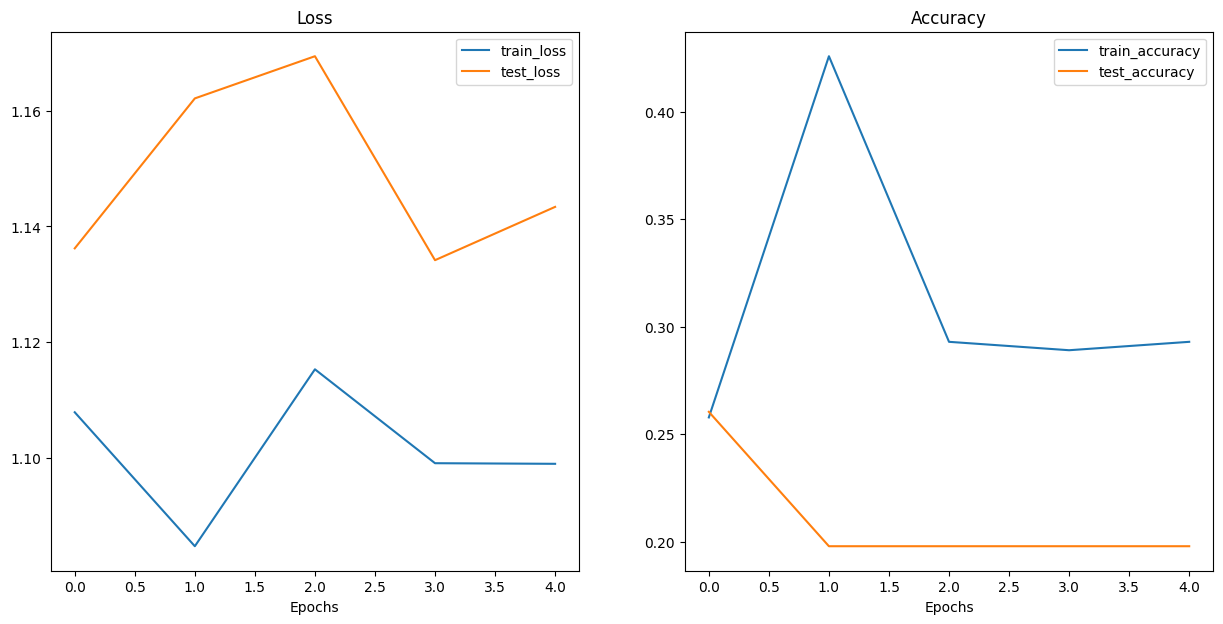

In [ ]:
plot_loss_curves(model_0_results)

## 8. What should an ideal loss curve look like?

url: https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

A loss curve is one of the most helpful ways to troubleshoot a model


## 9. Model 1: TinyVGG with Data Augmentation

### 9.1 Create transform with data augmentation

In [ ]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

### 9.2 Create train and test Dataset's and DataLoader's

In [ ]:
# turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [ ]:
#  tuen Datasets into DataLoader's
import os

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
torch.manual_seed(42)

train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple  = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader_simple


(<torch.utils.data.dataloader.DataLoader at 0x796a82d65780>,
 <torch.utils.data.dataloader.DataLoader at 0x796a82d67ac0>)

### 9.3 Construct and train Model 1

- training the same model architecture except the training data is augmented this time.

In [ ]:
# Create model_1 and send it to the target device
torch.manual_seed(42)

model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)
).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1076 | train_acc: 0.2500 | test_loss: 1.1062 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0791 | train_acc: 0.4258 | test_loss: 1.1387 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0811 | train_acc: 0.4258 | test_loss: 1.1696 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1291 | train_acc: 0.3047 | test_loss: 1.1623 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0901 | train_acc: 0.4258 | test_loss: 1.1477 | test_acc: 0.2604
Total training time: 7.718 seconds


### 9.4 Plot the loss curves of Model 1

A loss curve helps you evaluate your models performance overtime.

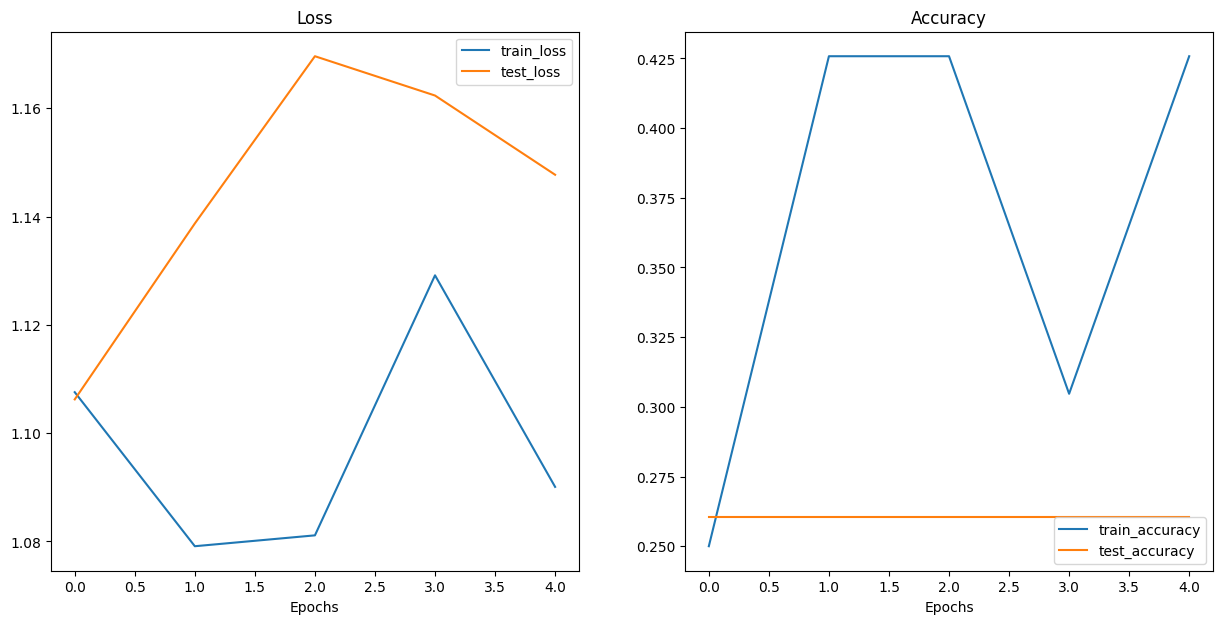

In [ ]:
plot_loss_curves(model_1_results)

## 10. Compare model results

After evaluating our modeling expironments on their own, it's important to compare them to eah other.

There's a few different ways to do this:

1. Hard coding (what we're doing)
2. PyTorch + Tensorboard - https://pytorch.org/docs/stable/tensorboard.html
3. Weights & Biases - https://wandb.ai/site/experiment-tracking
4. MLFlow - https://mlflow.org/

In [ ]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

train_loss  train_acc  test_loss  test_acc
0    1.107836   0.257812   1.136207  0.260417
1    1.084645   0.425781   1.162169  0.197917
2    1.115271   0.292969   1.169471  0.197917
3    1.099016   0.289062   1.134163  0.197917
4    1.098911   0.292969   1.143389  0.197917

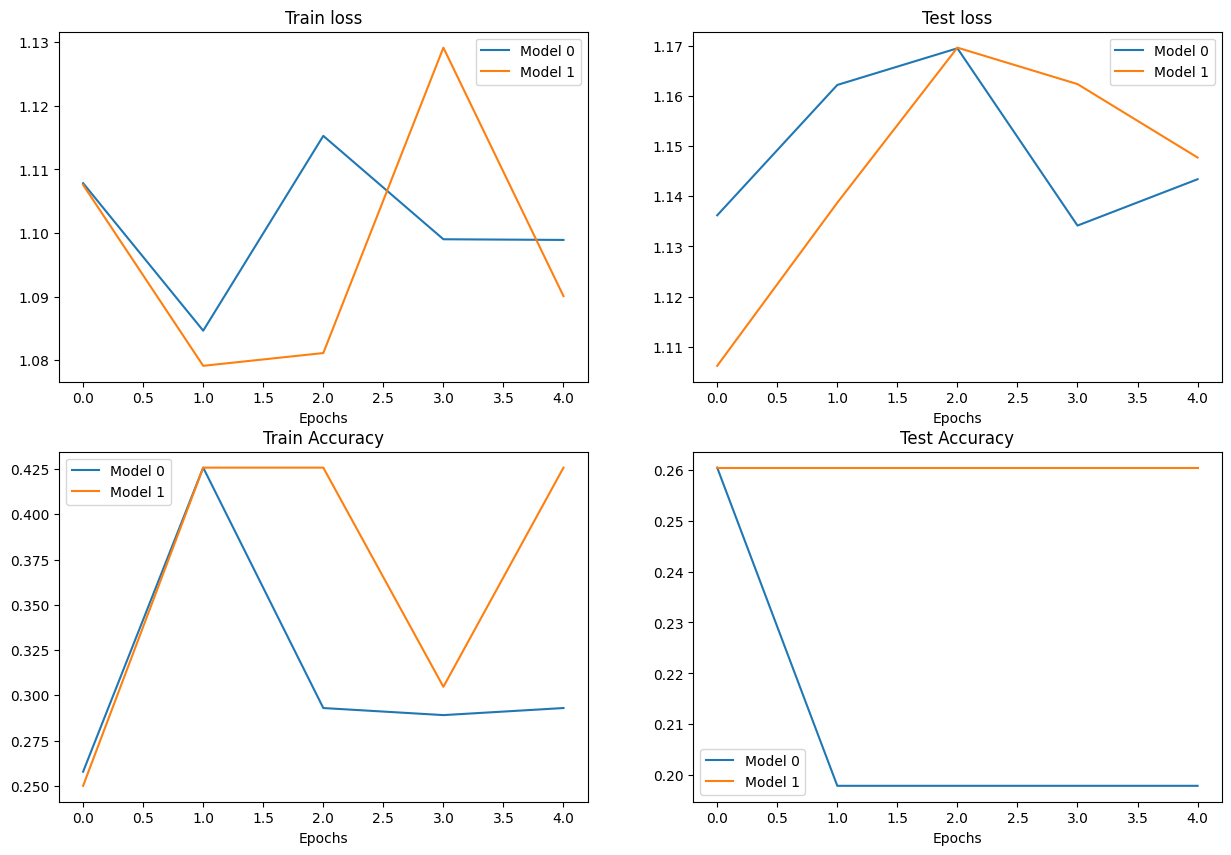

In [ ]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label='Model 0')
plt.plot(epochs, model_1_df["train_loss"], label='Model 1')
plt.title("Train loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label='Model 0')
plt.plot(epochs, model_1_df["test_loss"], label='Model 1')
plt.title("Test loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label='Model 0')
plt.plot(epochs, model_1_df["train_acc"], label='Model 1')
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label='Model 0')
plt.plot(epochs, model_1_df["test_acc"], label='Model 1')
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()

## 11. Make a prediction on custom image

Although we've trained a model on custome data...how do you make a prediction on a sample/image that's not in either training or testing dataset.

In [ ]:
# Download custom image
import requests

# Setup custom image path
# img_name = 'custom_pizza.jpg'
img_name = 'custom_steak.jpg'
custom_image_path = data_path / img_name
custom_image_path = data_path / 'steak_test1.jpg'

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://images.unsplash.com/photo-1588168333986-5078d3ae3976?q=80&w=1254&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D")
    # request = requests.get("https://images.unsplash.com/photo-1593560708920-61dd98c46a4e?q=80&w=1335&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download.")

data/steak_test1.jpg already exists, skipping download.


### 11.1 Loading in a custom image with PyTorch
We have to make sure out custom image is in the same format as the data out model was trained on

* In tensor form with datatype (torch.float32)
* of shape (64, 64, 3)
* On the right device

We can read an image into PyTorch using:
https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html

In [ ]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[94, 96, 97,  ..., 48, 56, 59],
         [94, 95, 92,  ..., 53, 61, 64],
         [94, 96, 95,  ..., 57, 64, 66],
         ...,
         [55, 59, 64,  ...,  8,  8,  9],
         [57, 66, 65,  ...,  6,  7,  7],
         [56, 64, 57,  ...,  9,  9, 10]],

        [[31, 33, 34,  ..., 10, 14, 17],
         [31, 32, 29,  ..., 13, 19, 22],
         [28, 30, 29,  ..., 17, 22, 24],
         ...,
         [39, 43, 48,  ...,  3,  3,  4],
         [43, 52, 51,  ...,  1,  2,  2],
         [42, 50, 43,  ...,  4,  4,  5]],

        [[16, 18, 17,  ...,  0,  2,  5],
         [16, 17, 12,  ...,  3,  7, 10],
         [14, 16, 15,  ...,  7, 10, 10],
         ...,
         [26, 30, 35,  ...,  0,  0,  1],
         [30, 39, 38,  ...,  0,  0,  0],
         [29, 37, 30,  ...,  1,  1,  2]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 384, 512])

Custom image dtype: torch.uint8


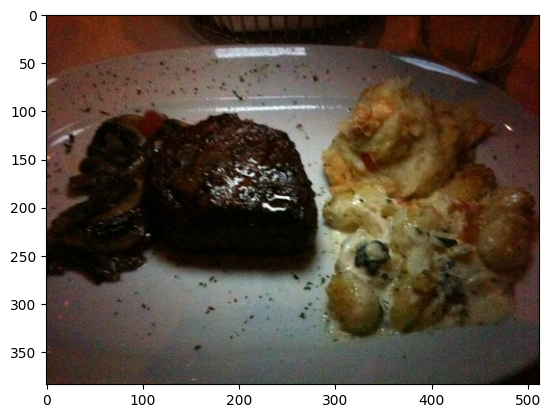

In [ ]:
plt.imshow(custom_image_uint8.permute(1, 2, 0))

### 11.2 Predicting on custom images with a trained PyTorch model



Nice! Looks like our image is in tensor format, however, is this image format compatible with our model?

Our custom_image tensor is of datatype torch.uint8 and its values are between [0, 255].

But our model takes image tensors of datatype torch.float32 and with values between [0, 1].

So before we use our custom image with our model, **we'll need to convert it to the same format as the data our model is trained on.**

In [ ]:
# Try to make a prediction on image in uint8 format (this will error!!!)
# model_1.eval()
# with torch.inference_mode():
#   model_1(custom_image_uint8.to(device))

Let's fix this by **converting our custom image to the same datatype** as what our model was trained on (**torch.float32**).

In [ ]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255.

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.3686, 0.3765, 0.3804,  ..., 0.1882, 0.2196, 0.2314],
         [0.3686, 0.3725, 0.3608,  ..., 0.2078, 0.2392, 0.2510],
         [0.3686, 0.3765, 0.3725,  ..., 0.2235, 0.2510, 0.2588],
         ...,
         [0.2157, 0.2314, 0.2510,  ..., 0.0314, 0.0314, 0.0353],
         [0.2235, 0.2588, 0.2549,  ..., 0.0235, 0.0275, 0.0275],
         [0.2196, 0.2510, 0.2235,  ..., 0.0353, 0.0353, 0.0392]],

        [[0.1216, 0.1294, 0.1333,  ..., 0.0392, 0.0549, 0.0667],
         [0.1216, 0.1255, 0.1137,  ..., 0.0510, 0.0745, 0.0863],
         [0.1098, 0.1176, 0.1137,  ..., 0.0667, 0.0863, 0.0941],
         ...,
         [0.1529, 0.1686, 0.1882,  ..., 0.0118, 0.0118, 0.0157],
         [0.1686, 0.2039, 0.2000,  ..., 0.0039, 0.0078, 0.0078],
         [0.1647, 0.1961, 0.1686,  ..., 0.0157, 0.0157, 0.0196]],

        [[0.0627, 0.0706, 0.0667,  ..., 0.0000, 0.0078, 0.0196],
         [0.0627, 0.0667, 0.0471,  ..., 0.0118, 0.0275, 0.0392],
         [0.0549, 0.0627, 0.0588,  ..

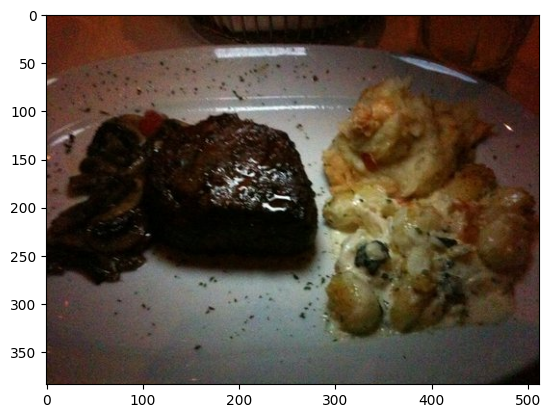

In [ ]:
plt.imshow(custom_image.permute(1, 2, 0))

In [ ]:
custom_image.shape

torch.Size([3, 384, 512])

In [ ]:
img.shape

torch.Size([1, 3, 64, 64])

In [ ]:
# Try to make a prediction on an image in uint8 format
# model_1.eval()
# with torch.inference_mode():
#   model_1(custom_image.to(device))

In [ ]:
# create transform pipeline to resize image
from torchvision import transforms
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64,64), antialias=True)
])

# tramsform target image
custom_image_transformed = custom_image_transform(custom_image)

In [ ]:
custom_image_transformed.shape

torch.Size([3, 64, 64])

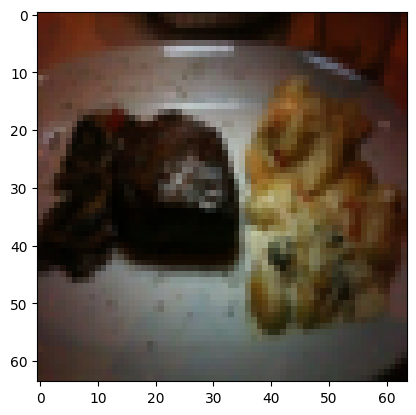

In [ ]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))

In [ ]:
#  This will error, no batch size
# model_1.eval()
# with torch.inference_mode():
#   custom_image_pred = model_1(custom_image_transformed.to(device))

In [ ]:
custom_image_transformed.shape

torch.Size([3, 64, 64])

In [ ]:
img.shape

torch.Size([1, 3, 64, 64])

In [ ]:
custom_image_transformed.unsqueeze(0).shape

torch.Size([1, 3, 64, 64])

In [ ]:
#  add a batch size
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))

In [ ]:
custom_image_pred

tensor([[ 0.1165,  0.0333, -0.1406]], device='cuda:0')

Note, to make a prediction on a custom image we had to:
* Load the image and turn it in the tensor
* Make sure the image was the same datatype as the model (torch.float32)
* Make sure the image was the same shape as the data the model was trained on (64x64x3) with a batch size (1, 3, 64, 64)
* Make sure the image was in the same device as our model

In [ ]:
class_names

['pizza', 'steak', 'sushi']

In [ ]:
# Convert logits -> prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.3713, 0.3416, 0.2871]], device='cuda:0')

In [ ]:
# Convert prediction probailities -> prediction labels
custom_image_pred_labels = torch.argmax(custom_image_pred_probs, dim=1)
custom_image_pred_labels

tensor([0], device='cuda:0')

In [ ]:
class_names[custom_image_pred_labels]

'pizza'

### 11.3 Putting custom image prediction together: building a function

ideal outcome:
A function where we pass an image path and have our model predict on that image and plot the image + prediction

In [ ]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device=device):
  """ Makes a prediction on a target image with a trained model and plots the image and prediction """
  # 1. Load the image and convrt the tensor values to float32
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
  # 2. Divide the image pixel values by 255 to get them between [0, 1]
  target_image = target_image / 255
  # 3. Transform if necessary
  if transform:
    target_image = transform(target_image)
  # 4. Make sure the model is on th right device
  model.to(device)
  # 5. Turn on model evaluation mode and inference mode
  model.eval()
  with torch.inference_mode():
    # Add an extra dimention to the image
    target_image = target_image.unsqueeze(dim=0)

    # Make a prediction on image with an extra dimension and send it to the target device
    target_image_pred = model(target_image.to(device))

  # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
  print(f"taeget_pred_prob: {target_image_pred_probs}")
  # 7. Convert prediction probabilities -> prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
  # 8. Plot the image alongside the prediction and predition probabilities
  plt.imshow(target_image.squeeze().permute(1, 2, 0))
  if class_names:
    # matplotlib can not use value from GPU, need convert to CPU
    title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  else:
    title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False)

taeget_pred_prob: tensor([[0.3713, 0.3416, 0.2871]], device='cuda:0')


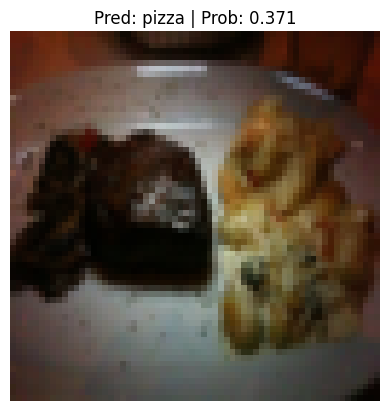

In [ ]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)